In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as scores
import matplotlib.pyplot as plt

import psycopg2
import pandas.io.sql as sqlio
import psycopg2.extras


In [2]:
# Establish a connection to the PLUTO database
try:
    conn = psycopg2.connect("dbname='pluto' user='oliver' host='localhost' password='m'")
except:
    print("I am unable to connect to the database")

# Create a cursor object for executing queries
conn.autocommit = True
cur = conn.cursor()

In [3]:
    cov = [
    'age'
    ,'build_alter_gap'
    ,'alterage'
    ,'alterage_squared'   
    ,'alterage_cubed'
    ,'elevator'
    ,'commercial'
    ,'garage'
    ,'storage'
    ,'basement'
    ,'waterfront'
    ,'frontage'
    ,'block_assmeblage'
    ,'cooperative'
    ,'conv_loft_wh'
    ,'tenament'
    ,'garden'
    ,'semi_fireproof'
    ,'fireproof'
    ,'luxury'
    ,'artist_res'
    ,'units_per_building'
    ,'floors'
    ,'floors_squared'
    ,'zip_avg_num_buildings'
    ,'pcvpu_l1'
    ,'pcvpu_l2'
    ,'pcvpu_l3'
    ,'avg_block_pcvpu_l1'
    ,'avg_block_pcvpu_l2'
    ,'avg_block_pcvpu_l3'
    ,'avg_neighbor1_pcvpu_l1'
    ,'avg_neighbor1_pcvpu_l2'
    ,'avg_neighbor1_pcvpu_l3'
    ,'avg_neighbor2_pcvpu_l1'
    ,'avg_neighbor2_pcvpu_l2'
    ,'avg_neighbor2_pcvpu_l3'
    ,'avg_neighbor3_pcvpu_l1'
    ,'avg_neighbor3_pcvpu_l2'
    ,'avg_neighbor3_pcvpu_l3'
    ,'avg_neighbor4_pcvpu_l1'
    ,'avg_neighbor4_pcvpu_l2'
    ,'avg_neighbor4_pcvpu_l3'
    ,'avg_zip_pcvpu_l1'
    ,'avg_zip_pcvpu_l2'
    ,'avg_zip_pcvpu_l3'
    ]

In [4]:
# Commands to select data from each year
sql_2008 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2008
         """
sql_2009 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2009
         """
sql_2010 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2010
         """
sql_2010 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2010
         """
sql_2011 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2011
         """
sql_2012 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2012
         """
sql_2013 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2013
         """
sql_2014 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2014
         """
sql_2015 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2015
         """
sql_2016 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2016
         """
sql_2017 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2017
         """
sql_2018 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2018
         """
sql_2019 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2019
         """
sql_2020 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2020
         """

In [5]:
# Function for creating dataframes from a SQL query
def get_data(sql_train, sql_test, cov):
    """
    Function to return data from a train and test SQL query
    """
    global df_train, df_test, X_train, X_test, y_train, y_test, covariates

    # List of columns to be used as covariates in the model

    df_train = sqlio.read_sql_query(sql_train, conn).dropna()
    df_test = sqlio.read_sql_query(sql_test, conn).dropna()

    covariates = df_train.columns.intersection(cov)

    X_train = df_train[covariates]
    y_train = df_train['pcvpu_target']

    X_test = df_test[covariates]
    y_test = df_test['pcvpu_target']
    return df_train, df_test, X_train, X_test, y_train, y_test

In [6]:
# Create a random forest classifier object
# warm_start = True allows the model to be trained on new data without having to retrain the entire model
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [7]:
# Set up empty lists to store the results of the model for each year

MAEs = [] ## Mean Absolute Error, list of numbers (out of sample)
R2s = []  ## R2 score, list of numbers (out of sample)
accuracies = [] ## Accuracy, list of numbers (out of sample)
precisions = [] ## Precision scores for each class, list of lists (out of sample)
recalls = [] ## Recall scores for each class, list of lists (out of sample)
f1scores = [] ## F1 score for each class, list of lists (out of sample)
supports = [] ## Support scores for each class, list of lists (out of sample)

feature_importances = [] ## Feature importances, list of lists

MAEs_in_sample = [] ## Mean Absolute Error, list of numbers (in sample)
R2s_in_sample = []  ## R2 score, list of numbers (in sample)
accuracies_in_sample = [] ## Accuracy, list of numbers (in sample)
precisions_in_sample = [] ## Precision scores for each class, list of lists (in sample)
recalls_in_sample = [] ## Recall scores for each class, list of lists (in sample)
f1scores_in_sample = [] ## F1 score for each class, list of lists (in sample)
supports_in_sample = [] ## Support scores for each class, list of lists (in sample)

def update_reports():
    """
    Function to update the reports for each year
    """
    print('Updating Out of Sample Reports')
    print(classification_report(y_test, y_pred))
    precision, recall, f1score, support = scores(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1score)
    supports.append(support)
    accuracies.append(accuracy_score(y_test, y_pred))
    MAEs.append(mean_absolute_error(y_test, y_pred))
    R2s.append(r2_score(y_test, y_pred))

    print('Updating In Sample Reports')
    print(classification_report(y_train, y_pred_in_sample))
    precision_in_sample, recall_in_sample ,f1score_in_sample, support_in_sample = scores(y_train, y_pred_in_sample)
    precisions_in_sample.append(precision_in_sample)
    recalls_in_sample.append(recall_in_sample)
    f1scores_in_sample.append(f1score_in_sample)
    supports_in_sample.append(support_in_sample)
    accuracies_in_sample.append(accuracy_score(y_train, y_pred_in_sample))
    MAEs_in_sample.append(mean_absolute_error(y_train, y_pred_in_sample))
    R2s_in_sample.append(r2_score(y_train, y_pred_in_sample))


In [8]:
# get data from 2008 and 2009
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2008, sql_2009, cov)


In [9]:
# fit the model for 2008 and 2009
lr.fit(X_train,y_train)

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [10]:
# Make in and out of sample predictions
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)

In [11]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.58      0.20      0.30     19654
           1       0.29      0.10      0.15     56098
           2       0.51      0.94      0.66     63793
           3       0.20      0.01      0.03      5531

    accuracy                           0.48    145076
   macro avg       0.39      0.31      0.28    145076
weighted avg       0.42      0.48      0.39    145076

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.55      0.45      0.49     16031
           1       0.35      0.10      0.15     45689
           2       0.61      0.95      0.74     75018
           3       0.33      0.05      0.09      6601

    accuracy                           0.58    143339
   macro avg       0.46      0.39      0.37    143339
weighted avg       0.51      0.58      0.49    143339



In [12]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2009, sql_2010, cov)

In [14]:
# expand the number of trees and then fit to the next year
lr.fit(X_train,y_train)

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [15]:
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)

In [16]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.26      0.25      0.25     14026
           1       0.47      0.15      0.22     65196
           2       0.43      0.86      0.57     56957
           3       0.43      0.01      0.03     12673

    accuracy                           0.42    148852
   macro avg       0.40      0.32      0.27    148852
weighted avg       0.43      0.42      0.34    148852

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.55      0.46      0.50     19654
           1       0.53      0.30      0.38     56098
           2       0.57      0.87      0.69     63793
           3       0.22      0.01      0.02      5531

    accuracy                           0.56    145076
   macro avg       0.47      0.41      0.40    145076
weighted avg       0.54      0.56      0.52    145076



In [17]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2010, sql_2011, cov)

In [18]:
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)

/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [19]:
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)

In [20]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.25      0.02      0.04     15426
           1       0.93      0.65      0.76    128361
           2       0.03      0.48      0.05      3039
           3       0.11      0.25      0.16      3339

    accuracy                           0.57    150165
   macro avg       0.33      0.35      0.25    150165
weighted avg       0.82      0.57      0.66    150165

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.45      0.13      0.20     14026
           1       0.57      0.80      0.67     65196
           2       0.46      0.37      0.41     56957
           3       0.50      0.30      0.37     12673

    accuracy                           0.53    148852
   macro avg       0.49      0.40      0.41    148852
weighted avg       0.51      0.53      0.50    148852



In [21]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2011, sql_2012, cov)

In [22]:
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)

/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [23]:
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)

In [24]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.20      0.03      0.06     11697
           1       0.34      0.98      0.50     51325
           2       0.19      0.00      0.00     77885
           3       0.31      0.00      0.01     10654

    accuracy                           0.34    151561
   macro avg       0.26      0.26      0.14    151561
weighted avg       0.25      0.34      0.18    151561

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.26      0.03      0.05     15426
           1       0.86      0.99      0.92    128361
           2       0.11      0.01      0.01      3039
           3       0.17      0.01      0.02      3339

    accuracy                           0.85    150165
   macro avg       0.35      0.26      0.25    150165
weighted avg       0.77      0.85      0.79    150165



In [25]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2012, sql_2013, cov)

In [26]:
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [27]:
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)

In [28]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.23      0.04      0.07     14892
           1       0.39      0.15      0.21     50865
           2       0.54      0.92      0.68     74913
           3       0.36      0.12      0.18     12179

    accuracy                           0.51    152849
   macro avg       0.38      0.31      0.29    152849
weighted avg       0.45      0.51      0.43    152849

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.42      0.09      0.14     11697
           1       0.49      0.26      0.34     51325
           2       0.58      0.88      0.70     77885
           3       0.42      0.20      0.27     10654

    accuracy                           0.56    151561
   macro avg       0.48      0.35      0.36    151561
weighted avg       0.53      0.56      0.50    151561



In [29]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2013, sql_2014, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.07      0.07      0.07      3813
           1       0.38      0.13      0.20     62233
           2       0.51      0.86      0.64     71827
           3       0.41      0.13      0.20     15432

    accuracy                           0.47    153305
   macro avg       0.34      0.30      0.28    153305
weighted avg       0.43      0.47      0.40    153305

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.32      0.13      0.18     14892
           1       0.42      0.17      0.24     50865
           2       0.56      0.90      0.69     74913
           3       0.37      0.19      0.25     12179

    accuracy                           0.52    152849
   macro avg       0.42      0.34      0.34    152849
weighted avg       0.47      0.52      0.45    152849



In [30]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2014, sql_2015, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.21      0.00      0.01      8551
           1       0.58      0.86      0.69     67924
           2       0.71      0.53      0.60     63672
           3       0.36      0.15      0.21     13906

    accuracy                           0.61    154053
   macro avg       0.47      0.39      0.38    154053
weighted avg       0.59      0.61      0.57    154053

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.16      0.01      0.02      3813
           1       0.65      0.49      0.56     62233
           2       0.61      0.82      0.70     71827
           3       0.43      0.26      0.32     15432

    accuracy                           0.61    153305
   macro avg       0.46      0.40      0.40    153305
weighted avg       0.60      0.61      0.59    153305



In [31]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2015, sql_2016, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.15      0.02      0.03      5262
           1       0.48      0.73      0.57     56597
           2       0.71      0.52      0.60     81847
           3       0.29      0.22      0.25     11251

    accuracy                           0.55    154957
   macro avg       0.41      0.37      0.36    154957
weighted avg       0.58      0.55      0.54    154957

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.23      0.01      0.03      8551
           1       0.63      0.81      0.71     67924
           2       0.68      0.62      0.65     63672
           3       0.36      0.21      0.27     13906

    accuracy                           0.63    154053
   macro avg       0.47      0.41      0.41    154053
weighted avg       0.60      0.63      0.61    154053



In [32]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2016, sql_2017, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.20      0.00      0.00      4667
           1       0.59      0.33      0.42     57630
           2       0.62      0.91      0.74     81767
           3       0.27      0.08      0.12     11150

    accuracy                           0.61    155214
   macro avg       0.42      0.33      0.32    155214
weighted avg       0.57      0.61      0.56    155214

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.18      0.00      0.00      5262
           1       0.57      0.31      0.41     56597
           2       0.63      0.92      0.74     81847
           3       0.26      0.09      0.13     11251

    accuracy                           0.61    154957
   macro avg       0.41      0.33      0.32    154957
weighted avg       0.56      0.61      0.55    154957



In [33]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2017, sql_2018, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.92      0.00      0.00     90097
           1       0.01      0.11      0.02      2978
           2       0.02      0.89      0.04      2722
           3       0.04      0.00      0.00     54260

    accuracy                           0.02    150057
   macro avg       0.25      0.25      0.02    150057
weighted avg       0.57      0.02      0.00    150057

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.26      0.00      0.01      4667
           1       0.58      0.38      0.46     57630
           2       0.64      0.88      0.74     81767
           3       0.29      0.09      0.13     11150

    accuracy                           0.61    155214
   macro avg       0.44      0.34      0.34    155214
weighted avg       0.58      0.61      0.57    155214



In [34]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2018, sql_2019, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.22      0.59      0.32     35174
           1       0.26      0.00      0.00     33758
           2       0.17      0.00      0.00     26029
           3       0.43      0.46      0.44     55470

    accuracy                           0.31    150431
   macro avg       0.27      0.26      0.19    150431
weighted avg       0.30      0.31      0.24    150431

Updating In Sample Reports


/home/oliver/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oliver/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oliver/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.82      0.83      0.83     90097
           1       0.00      0.00      0.00      2978
           2       0.00      0.00      0.00      2722
           3       0.69      0.74      0.72     54260

    accuracy                           0.77    150057
   macro avg       0.38      0.39      0.39    150057
weighted avg       0.74      0.77      0.76    150057



/home/oliver/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2019, sql_2020, cov)
# expand the number of trees and then fit to the next year

lr.fit(X_train,y_train)
# make predictions for the next year
y_pred = lr.predict(X_test)
y_pred_in_sample = lr.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/oliver/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.56      0.05      0.09    100812
           1       0.08      0.03      0.04     28247
           2       0.13      0.00      0.01      8548
           3       0.09      0.87      0.16     13573

    accuracy                           0.12    151180
   macro avg       0.21      0.24      0.08    151180
weighted avg       0.40      0.12      0.09    151180

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.31      0.03      0.05     35174
           1       0.38      0.27      0.31     33758
           2       0.09      0.00      0.00     26029
           3       0.40      0.89      0.55     55470

    accuracy                           0.39    150431
   macro avg       0.29      0.29      0.23    150431
weighted avg       0.32      0.39      0.28    150431



Text(0.5, 1.0, 'Accuracy Score by Year')

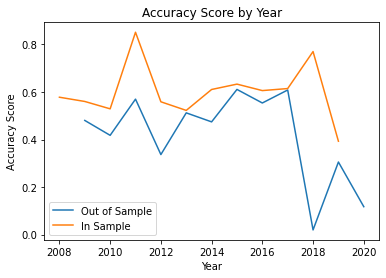

In [38]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years_in_sample = [2008 ,2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, accuracies, label='Out of Sample')
plt.plot(years_in_sample, accuracies_in_sample, label='In Sample')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Year')


Text(0.5, 1.0, 'Out of Sample F1 Scores by Year')

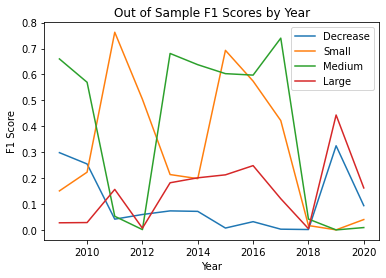

In [41]:
plt.plot(years, f1scores)
plt.legend(['Decrease','Small','Medium','Large'])
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('Out of Sample F1 Scores by Year')

Text(0.5, 1.0, 'In Sample F1 Scores by Year')

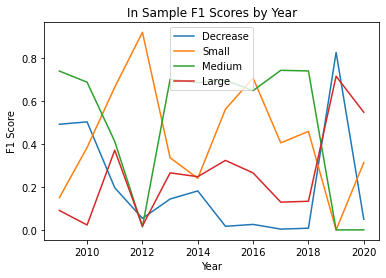

In [42]:
plt.plot(years, f1scores_in_sample)
plt.legend(['Decrease','Small','Medium','Large'])
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('In Sample F1 Scores by Year')

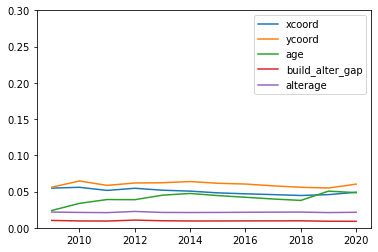

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][:5] for i in range(len(feature_importances))])
plt.legend(cov[:5])

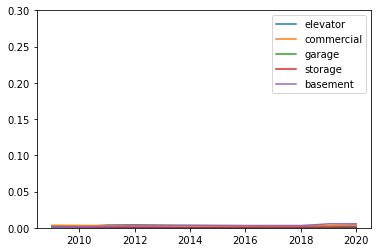

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][5:10] for i in range(len(feature_importances))])
plt.legend(cov[5:10])

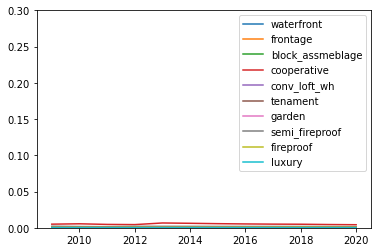

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][10:20] for i in range(len(feature_importances))])
plt.legend(cov[10:20])

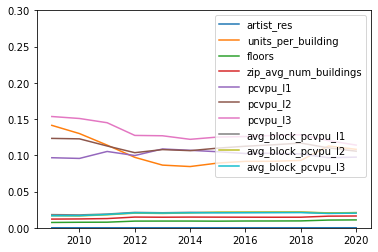

In [ ]:
plt.axis([None, None, 0, 0.3])

plt.plot(years, [feature_importances[i][20:30] for i in range(len(feature_importances))])
plt.legend(cov[20:30])

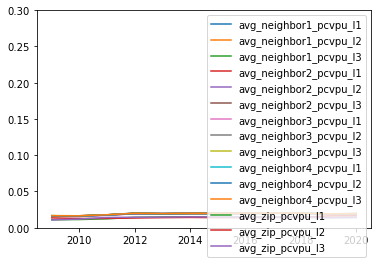

In [ ]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][30:] for i in range(len(feature_importances))])
plt.legend(cov[30:])